In [1]:
from hw2 import *
np.random.seed(123)

In [2]:
def synthesize(population_prob, n=1):
    """Utility function to simulate sampling from a population.
    Each column is sampled with the coin-flip probability defined in population_prob."""
    x = np.random.binomial(n=1, p=population_prob, size=(n, len(population_prob)))
    x[x == 0] = -1
    return x


## TEST STATISTICS
def test_homer(alice, sample_mean, population_mean):
    """Calculates the Homer test statistic"""
    test_statistic = sum(abs(alice - population_mean) - abs(alice - sample_mean))
    return test_statistic


def test_dwork(alice, sample_mean, population_mean):
    """Calculates the Dwork et al. test statistic using the population means
    Let `population_mean=referent` if using only a single individual from the population as a referent.
    """
    return np.dot(alice - population_mean, sample_mean - population_mean)


def null_distribution(fun, population_prob, population_mean, null_sims=1000, alpha=0.05):
    """Simulates the null distribution"""
    # A null distribution and critical value generator
    hold = []

    for i in range(null_sims):
        sample_mean = synthesize(population_prob, n=10).mean(axis=0)
        null_alice = synthesize(population_prob)[0]
        # referent = synthesize(population_prob)[0]

        hold.append(fun(null_alice, sample_mean, population_mean))

    null_dist_vals = np.sort(hold)[::-1]
    return {
        "nulldist": null_dist_vals,
        "critical_val": null_dist_vals[round(alpha * null_sims)]
    }


In [3]:
def execute_means_exact(dat, predicates):
    """Evaluate predicates on the dataset 'dat' and return the means."""
    return dat[target].values @ np.stack([pred(dat) for pred in predicates], axis=1)/len(dat)

In [4]:
def membership_attack(answers, alice, pop_params):
    """Perform membership attack using dwork et al. test statistic.
    :return: True if alice is in data."""

    population_mean = 2 * pop_params - 1. 

    output = null_distribution(test_dwork, pop_params, population_mean)
    critical_value = output["critical_val"]

    # membership attack here
    test_statistic = test_dwork(alice=alice, sample_mean=answers, population_mean=population_mean)
    dwork_membership_success = (test_statistic > critical_value)
    return dwork_membership_success

In [5]:
import time

small_data: pd.DataFrame = pd.read_csv(
    "https://raw.githubusercontent.com/opendp/cs208/main/spring2022/data/FultonPUMS5full.csv")\
    .sample(n=50)

num_trials = 10
fp_results = []
tp_results = []

num_predicates = np.arange(2, 6) * 100
for d in num_predicates:
    fp = 0
    tp = 0

    print('Predicate space dimensionality:', d)

    start_time = time.time()
    for i in tqdm(range(num_trials)):
        
        # regenerate predicates for each trial
        predicates = [make_random_predicate() for _ in range(d)]

        sample_mean = execute_means_exact(small_data, predicates)

        # alice is in the sample (Fulton) and null_alice is from the population (U.S.)
        # use the following population parameters
        # (imagine whole of U.S. is the population and Fulton is below it so we see a clear signal)
        pop_params = np.random.uniform(0.5, 1.0, d)

        null_alice = synthesize(population_prob=pop_params, n=1)[0]
        fp += membership_attack(sample_mean, null_alice, pop_params)

        alice = synthesize(population_prob=sample_mean, n=1)[0]
        tp += membership_attack(sample_mean, alice, pop_params)

    print(f"{time.time() - start_time} seconds")
    fp_results.append(fp / num_trials)
    tp_results.append(tp / num_trials)

print(fp_results)
print(tp_results)

Predicate space dimensionality: 200


100%|██████████| 10/10 [00:04<00:00,  2.11it/s]


4.750848770141602 seconds
Predicate space dimensionality: 300


100%|██████████| 10/10 [00:06<00:00,  1.54it/s]


6.479694366455078 seconds
Predicate space dimensionality: 400


100%|██████████| 10/10 [00:08<00:00,  1.22it/s]


8.23595118522644 seconds
Predicate space dimensionality: 500


100%|██████████| 10/10 [00:10<00:00,  1.00s/it]

10.040699243545532 seconds
[0.1, 0.0, 0.0, 0.0]
[1.0, 1.0, 1.0, 1.0]


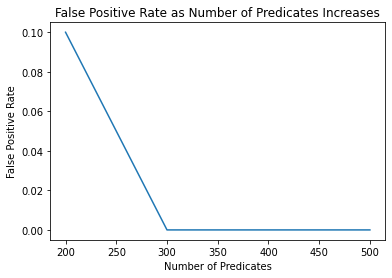

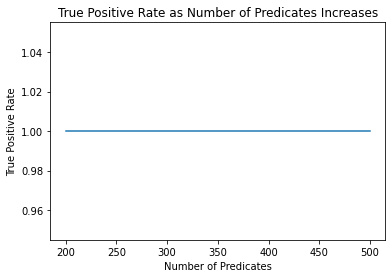

In [6]:
import matplotlib.pyplot as plt

plt.plot(num_predicates, fp_results)
plt.xlabel("Number of Predicates")
plt.ylabel("False Positive Rate")
plt.title("False Positive Rate as Number of Predicates Increases")
plt.show()

plt.plot(num_predicates, tp_results)
plt.xlabel("Number of Predicates")
plt.ylabel("True Positive Rate")
plt.title("True Positive Rate as Number of Predicates Increases")
plt.show()